# Now for multiple reactions

In [14]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

In [84]:
# Create a stoichiometric matrix of 3 reactions, lets use module 1 from the paper

stoich_matrix_1 = Matrix( [[-1,1,0], [1,-1,-1], [0,0,1], [-1,0,-1], [0,1,0]])

num_internal_species = 3

species_names = ["A", "B","C","D","E"]


# need to define stoichiometry for the reverse reaction

SM = []

for p in range(stoich_matrix_1.cols):
    SM.append(stoich_matrix_1[:, p])
    SM.append(-stoich_matrix_1[:, p])

SM_with_reverse_stoichiometry = Matrix.hstack(*SM)

SM_with_reverse_stoichiometry


Matrix([
[-1,  1,  1, -1,  0,  0],
[ 1, -1, -1,  1, -1,  1],
[ 0,  0,  0,  0,  1, -1],
[-1,  1,  0,  0, -1,  1],
[ 0,  0,  1, -1,  0,  0]])

In [69]:
stoich_matrix_1[:,1][1]

-1

the reactions for the stoichiometric matrix above read like: (reversible)

A + D = B ,B = A + E, B + D = C

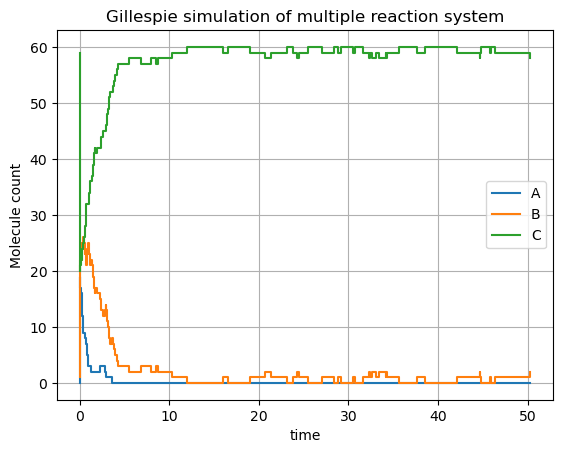

Final A: 0
Final B: 2
Final C: 58


In [ ]:
# initial conditions

#NA, NB, NC, ND, NE = 20, 20, 20, 50, 50            # initial pop count for each species
current_pops = [20,20,20,50,50]

t, T = 0.0, 50.0                               # initial and final time

times, A_counts, B_counts, C_counts, D_counts, E_counts  = [t], [NA], [NB], [NC], [ND], [NE]

counts_list = [A_counts,B_counts,C_counts,D_counts,E_counts]

kf_1, kb_1, kf_2, kb_2, kf_3, kb_3 = 0.0105, 0.01, 0.0105, 0.01, 0.0105, 0.01


number_of_reactions = int(0.5*len(I)) # since each reaction is reversible, we have half as many as in the I vector

# algorithm:

while t < T:

    #propensity_vector = [kf_1*NA*ND,  kb_1*NB, kf_2*NB, kb_2*NA*NE, kf_3*NB*ND, kb_3*NC] # this reads as: probability rate for each reaction (rate * combinatorics_of_species)
    propensity_vector = [kf_1*current_pops[0]*current_pops[3], kb_1*current_pops[1] \
                         , kf_2*current_pops[1], kb_2*current_pops[0]*current_pops[4] \
                         , kf_3*current_pops[1]*current_pops[4], kb_3*current_pops[2]]
    
    a0 = np.sum(propensity_vector)

    if a0 == 0:
        break

    r1, r2 = np.random.rand(2) # draw two random numbers - how random are they, use qiskit for quanutm randomness?

    tau = -1*np.log(r1) / a0

    # Now need to select which reaction will occur using r2, prob is weighted by which is most likely to occur at the current state of the system:

    target_value = r2*a0

    cumulative = 0

    for n in range(len(propensity_vector)):

        cumulative += propensity_vector[n]

        if target_value <= cumulative:

            reaction_chosen = n

            break


    # perform updates

    t += tau

    stoich_vector = SM_with_reverse_stoichiometry[:,reaction_chosen] # selects the reaction we will perform


    # population change depending on stoichiometric vector

    for m in range(num_internal_species):

        current_pops[m] += stoich_vector[m] # ensure order of populations in list is same as rows in SM

    #current_populations[0] += stoich_vector[0]; NB += stoich_vector[1]; NC += stoich_vector[2]
    
    # lets fix the chemostat species to see evolution of species inside, (comment out next line)
    #ND += stoich_vector[3,0]; NE += stoich_vector[4,0]

    # update the counts

    times.append(t)

    for m in range(len(species_names)):
        
        counts_list[m].append(current_pops[m])
        #A_counts.append(NA); B_counts.append(NB); C_counts.append(NC); D_counts.append(ND); E_counts.append(NE) # sample counts at each point

# Plot results

for m in range(num_internal_species):
        
    plt.step(times, counts_list[m], where="post", label=species_names[m])

plt.xlabel("time"); plt.ylabel("Molecule count")
plt.grid(True)
plt.title("Gillespie simulation of multiple reaction system")
plt.legend(); plt.show()


# print final counts

for m in range(num_internal_species):
        
    print(r'Final {}: {}'.format(species_names[m], counts_list[m][-1]))
    


we want to sample the resistance of each reaction at every iteration as r_i = f_i/j_i. so we need force and current along each reaction

what we have already: population count of each species

since resistance matrix is diagonal full of resistances along each reaction, we can create our own resistance matrices at every sample step of the gillespie by doing r = j/f OR we could directly calculate a conductance matrix by doing g = 1/r = f/j for each reaction.

So, how do we sample the forces and currents?

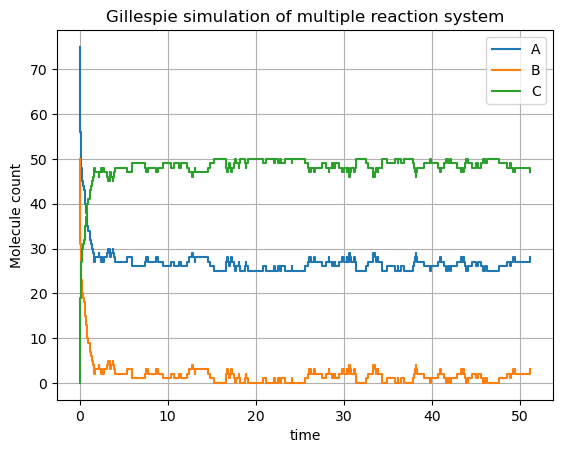

Final A: 28
Final B: 3
Final C: 47


In [31]:
# lets run a single reaction that is REVERSIBLE: i.e 2 reactions

# A + B -> C
# C -> A + B

new_SM = Matrix([[-1, -1, 1], [1,1,-1]]).T

# initial conditions
NA, NB, NC = 75, 50, 0                    # initial count of each species, this has input species as 100, output as 0, internals at 50 each
t, T = 0.0, 50.0                               # initial and final time
times, A_counts, B_counts, C_counts = [t], [NA], [NB], [NC]

I = [1,1]

# algorithm:

while t < T:

    propensity_vector = [0.04*NA*NB, 0.03*NC] # this reads as: probability rate for each reaction (rate * combinatorics_of_species)

    a0 = np.sum(propensity_vector)

    if a0 == 0:
        break

    r1, r2 = np.random.rand(2) # draw two random numbers - how random are they, use qiskit for quanutm randomness?

    tau = 1/a0 * np.log(1/r1)

    # Now need to select which reaction will occur using r2, prob is weighted by which is most likely to occur at the current state of the system:

    target_value = r2*a0

    cumulative = 0

    for n in range(len(propensity_vector)):

        cumulative += propensity_vector[n]

        if target_value <= cumulative:

            reaction_chosen = n

            break


    # perform updates

    t += tau

    stoich_vector = new_SM[:,reaction_chosen] # selects the reaction we will perform

        # population change depending on stoichiometric vector

    NA += stoich_vector[0,0]; NB += stoich_vector[1,0]; NC += stoich_vector[2,0]


    times.append(t); A_counts.append(NA); B_counts.append(NB); C_counts.append(NC) # sample counts at each point

plt.step(times, A_counts, where="post", label="A")
plt.step(times, B_counts, where="post", label="B")
plt.step(times, C_counts, where="post", label="C")

plt.xlabel("time"); plt.ylabel("Molecule count")
plt.grid(True)
plt.title("Gillespie simulation of multiple reaction system")
plt.legend(); plt.show()

print(r'Final A: {}'.format(A_counts[-1]))
print(r'Final B: {}'.format(B_counts[-1]))
print(r'Final C: {}'.format(C_counts[-1]))


In [32]:
new_SM

Matrix([
[-1,  1],
[-1,  1],
[ 1, -1]])